# Graph Fraud Detection with Neptune ML 

## 1- Feature Engineering 

In this module, we will run an end to end pipeline to train a fraud detection model using graph neural networks. The steps will include the following:


* Fraud detection dataset
* Export and Processing
* Model training
* Inference queries


**Fraud Detection** is a set of techniques and analyses that allow organizations to identify and prevent unauthorized activity. Fraud can also be any kind of abuse to the system in place to gain undeserved benefits.  This can include fraudulent credit card transactions, identify theft, insurance scams, etc. Fraudesters can collude to commit illegal activities and strive to make it look normal so it can be difficult to detect. The most effective solutions that fights fraud use a multifaceted approaches that integrates several of techniques. One of these techniques is the use of graphs.

Graphs allow us to understand the relationship between various entities and how they are connected together which help in detecting fraud patterns that couldn't be detected by traditional methods. In this workshop, we will go through building a ML model from a graph database and train a graph neural network to estimate the probability of fraud for a certain transaction.

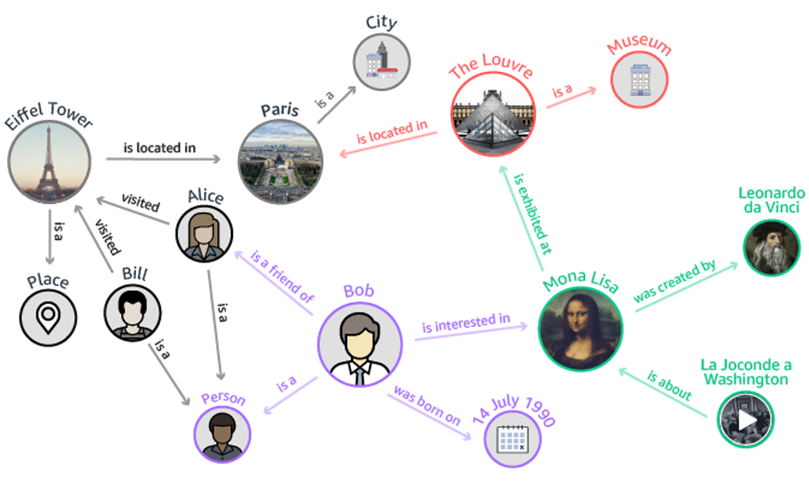

### 1- Environment Setup


We need to install some libraries to communicate with Neptune and Neptune ML evironment.


The first step is to build the Neptune DB cluster and wait for it to become ready.You can use a CloudFormation template from this [LINK](https://docs.aws.amazon.com/neptune/latest/userguide/get-started-create-cluster.html)

Once the template is completely deployed, make a note of the template output as we will need them in the second step

After the CloudFormation template is completely deployed, make a note of the **Neptune cluster endpoint**, **export API URL** and **Neptune load role** then replace the values below

In [ ]:
!pip install -U sagemaker boto3 awscurl kaggle

In [ ]:
!pip install networkx ipython-gremlin

### 2- Define the Variables

Replace the `NEPTUNE ENDPOINT` variable with the endpoint name. You can find the endpoint name in the CloudFormation template output

In [ ]:
import boto3
from botocore.config import Config
import sagemaker
import itertools
import re

config = Config(
   retries = {
      'max_attempts': 20,
      'mode': 'adaptive'
   }
)

#Define some variables to be used by later steps
client = boto3.client('sagemaker', config=config)
sagemaker_session = sagemaker.Session(sagemaker_client = client)
BUCKET = sagemaker_session.default_bucket()
REGION = boto3.session.Session().region_name
ACCOUNT_ID = boto3.client('sts').get_caller_identity().get('Account')
PREFIX = 'credit-transaction-fraud'

NEPTUNE_INSTANCE_ID = '<NEPTUNE_INSTANCE_ID>' #Replace this value with the actual instance ID for the Neptune cluster
NEPTUNE_ENDPOINT = 'NEPTUNE_ENDPOINT' #Replace this value with the one generated from the CFN template
NEPTUNE_LOAD_ROLE = 'arn:aws:iam::'+ACCOUNT_ID+':role/NeptuneLoadFromS3'

### 3- Establish Connection with Neptune Graph

The next cell of code will establish a connection with the Neptune graph DB using a python wrapper around Apache TinkerPop Gremlin. Apache TinkerPop is a graph computing framework for both graph databases (OLTP) and graph analytic systems (OLAP). Gremlin is the graph traversal language of TinkerPop. It is a functional, data-flow language that enables users to write complex traversals on (or queries of) their application’s property graph. 

Once we establish the remote graph connection, we can traverse through the graph and run different queries on the graph object

In [ ]:
from __future__  import print_function  # Python 2/3 compatibility

from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

graph = Graph()

remoteConn = DriverRemoteConnection('wss://'+NEPTUNE_ENDPOINT+':8182/gremlin','g')
g = graph.traversal().withRemote(remoteConn)

### 4- Download and Prepare the Data

In this example, we will use [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data?select=train_transaction.csv) dataset: financial transactions dataset in its raw form consisting of two tables:
 * **Transactions**: Records transactions and metadata about transactions between two users.
 * **Identity**: Contains various identifiers associated with a particular transactions.

#### 4.1 Download the Dataset

If you get an authentication error, you need to sign up for a Kaggle account, save your credentials in  `/home/ec2-user/.kaggle/kaggle.json`. Details are explained here: https://www.kaggle.com/docs/api

**NOTE** if you haven't downloaded the Kaggle configration file, the command below will fail

In [ ]:
# Dowload the dataset
!kaggle competitions download -c ieee-fraud-detection
!mkdir ./ieee-cis; unzip -o ieee-fraud-detection.zip -d ./ieee-cis

In [ ]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
transaction_df = pd.read_csv('./ieee-cis/train_transaction.csv')
id_df = pd.read_csv('./ieee-cis/train_identity.csv')

#### 4.2 Remove Columns with > 40% Missing Values

To avoid large scale imputation and changing data distribution, and for the purposes of this excercise, we will remove columns that has more than 40% missing values.

##### 4.2.1 Identity Table Remove Missing

In [ ]:
percent_missing_id = id_df.isnull().sum() * 100 / len(id_df)
missing_value_id_df = pd.DataFrame({'column_name': id_df.columns,
                                 'percent_missing': percent_missing_id})
missing_value_id_df.sort_values('percent_missing', inplace=True)
id_missing_df = missing_value_id_df[missing_value_id_df['percent_missing'] > 40]

for col in id_missing_df['column_name']:
    id_df.drop(col, inplace=True, axis=1)

##### 4.2.1 Transactions Table Remove Missing

In [ ]:
percent_missing = transaction_df.isnull().sum() * 100 / len(transaction_df)
missing_value_df = pd.DataFrame({'column_name': transaction_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
transation_missing_df = missing_value_df[missing_value_df['percent_missing'] > 40]

for col in transation_missing_df['column_name']:
    transaction_df.drop(col, inplace=True, axis=1)

### 5- Prepare the Graph Files
Graphs consists of nodes or vertices and edges. We will take each logical entity in our table and that will be our vertices and nodes. The identities and resulting entities will be connected by transaction ID so we will build our edges from this connection.

This notebook will build 4 different entities and their properties then the edges and connections between entities. The 4 entities are: **Devices, Cards, Identities and Transactions**

#### 5.1 Create Graph Entities

In [ ]:
#Create devices node
device_node_df = id_df[['DeviceType', 'DeviceInfo', 'TransactionID']]
device_node_df['~id'] = 'dev-' + device_node_df['TransactionID'].astype(str)
device_node_df['~label'] = 'Device'
device_node_df['edge_label'] = 'associated_with'
device_node_df_v = device_node_df.drop('TransactionID', axis=1)

device_node_df_v = device_node_df_v.rename(columns={'DeviceType': 'DeviceType:string','DeviceInfo': 'DeviceInfo:string'})

In [ ]:
#Create the cards entity

card_cols =[col for col in transaction_df if col.startswith('card')]
card_cols.append('TransactionID')
card_node_df = transaction_df[card_cols]
card_node_df['~id'] = 'card-' + card_node_df['TransactionID'].astype(str)
card_node_df['~label'] = 'Card'
card_node_df['edge_label'] = 'purchased_by'
card_node_df_v = card_node_df.drop('TransactionID', axis=1)

card_node_df_v = card_node_df_v.rename(columns={'card1': 'card1:float'})

In [ ]:
#Buidling the identity node

id_cols =[col for col in id_df if col.startswith('id') ] 
id_cols.append('TransactionID')
id_node_df = id_df[id_cols]
id_node_df['~id'] = 'id-' + id_node_df['TransactionID'].astype(str)
id_node_df['~label'] = 'Identifier'
id_node_df['edge_label'] = 'identified_by'

#rename columns to the correct type
regexp = re.compile('id_0[1-9]|id_1[0-1]')
numerical_cols = [col for col in id_df if regexp.search(col) ]
for colX in numerical_cols:
    id_node_df = id_node_df.rename(columns={colX: colX+':float'})
    

id_node_df_v = id_node_df.drop('TransactionID', axis=1)

In [ ]:
# Address and Product information will be properties to the identity node

C_cols = [col for col in transaction_df if col.startswith('C')]
D_cols = [col for col in transaction_df if col.startswith('D')]
V_cols = [col for col in transaction_df if col.startswith('V')]
M_cols = [col for col in transaction_df if col.startswith('M')]
dist_cols =[col for col in transaction_df if col.startswith('dist') or col.startswith('Prod') or col.startswith('addr')]
transaction_cols = C_cols + D_cols + V_cols + M_cols + dist_cols + ['TransactionDT', 'TransactionAmt', 'isFraud', 'TransactionID', 'P_emaildomain']
transaction_node_df = transaction_df[transaction_cols]
transaction_node_df['~label'] = 'Transaction'

#rename columns to correct type
for colX in C_cols:
    transaction_node_df = transaction_node_df.rename(columns={colX: colX+':float'})
for colX in D_cols:
    transaction_node_df = transaction_node_df.rename(columns={colX: colX+':float'})
for colX in V_cols:
    transaction_node_df = transaction_node_df.rename(columns={colX: colX+':float'})


transaction_node_df.rename(columns={'TransactionID': '~id', 'TransactionDT': 'TransactionDT:float', 'TransactionAmt': 'TransactionAmt:float'}, inplace=True)

transaction_node_df.to_csv('data/transaction_vertices.csv', index=None)

#### 5.2 Create Graph Edges

In [ ]:
import uuid
edge_cols = ['TransactionID','~id', 'edge_label']
frames = [id_node_df[edge_cols], card_node_df[edge_cols], device_node_df[edge_cols] ]
edges = pd.concat(frames)


edges['edge_id'] = edges.apply(lambda _: uuid.uuid4(), axis=1)
edges_df = edges.rename(columns={'TransactionID': '~from','~id': '~to','edge_label': '~label','edge_id': '~id'})
edges_df.to_csv('data/edges.csv', index=None)

#### 5.3 Save Graph Entities and Edges

In [ ]:
device_node_df_v.drop('edge_label', axis=1, inplace=True)
card_node_df_v.drop('edge_label', axis=1, inplace=True)
id_node_df_v.drop('edge_label', axis=1, inplace=True)

device_node_df_v.to_csv('data/device_vertices.csv', index=None)
card_node_df_v.to_csv('data/card_vertices.csv', index=None)
id_node_df_v.to_csv('data/id_vertices.csv', index=None)

### 6- Store Variables

In [ ]:
%store BUCKET
%store REGION
%store ACCOUNT_ID
%store PREFIX
%store NEPTUNE_ENDPOINT
%store NEPTUNE_LOAD_ROLE